In [233]:
# Importing libraries and dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_digits
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor

print(".")

.


In [234]:
#downloading the MNIST dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

type(training_data), len(training_data), training_data.data.shape

(torchvision.datasets.mnist.MNIST, 60000, torch.Size([60000, 28, 28]))

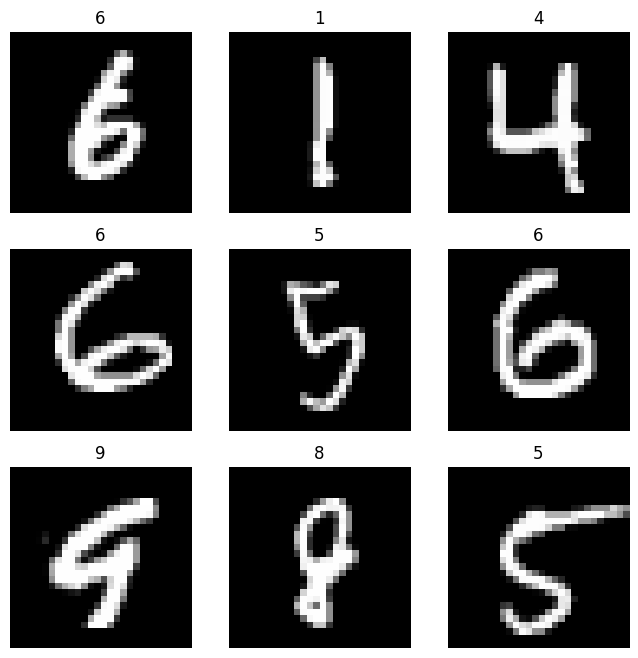

In [235]:
#visualize the labels map
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [236]:
# create dataloaders for the train and test set
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1000, shuffle=True)

type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [237]:
#network 1: applying 2d convolution, dropout2d, and linear transformation
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #flatten
        self.fc1 = nn.Linear(320, 50) #320
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [238]:
#check to see that it works on the input data we will pass in
input = torch.randn(1, 1, 28, 28)
out = network(input)
print(out)

tensor([[-2.4680, -2.3241, -2.4465, -2.1292, -2.4854, -2.0555, -2.3951, -2.3723,
         -2.2375, -2.2130]], grad_fn=<LogSoftmaxBackward0>)


C:\Users\alkal\AppData\Local\Temp\ipykernel_20276\654680725.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [239]:
params = list(network.parameters())
print(len(params))
print(params[0].size())

8
torch.Size([10, 1, 5, 5])


In [240]:
# Define parameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False
torch.manual_seed(0)

network = Net()
#using the stochastic gradient descent optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]

In [241]:
#training the network
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network(data)
    #loss function: negative log likelihood
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_dataloader.dataset),
        100. * batch_idx / len(train_dataloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))
      #torch.save(network.state_dict(), 'results/model.pth')
      #torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [242]:
#function to test the network on the validation set
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dataloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_dataloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))

In [243]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test() #after 3 epochs we achieve accuracy of 96%

C:\Users\alkal\AppData\Local\Temp\ipykernel_20276\654680725.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\alkal\anaconda3\envs\c140\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3039, Accuracy: 987/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297314
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.302465
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.323880
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296098
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.311837
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.284443
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.308383
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.296021
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.301577
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.302344
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.290155
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.281338
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.298939
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.303516
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.269983
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.280778
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.280603
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.271497
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.287923
Train Epoch: 1 [12160/

In [244]:
#network 2: using only linear transformations with rectified linear activation function
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(784, 50)
        self.linear2 = nn.Linear(50, 50)
        self.linear3 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))  
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [245]:
#check to see that the network works properly on the input shape we pass in
input = torch.randn(1, 1, 28, 28)
out = network(input)
print(out)

tensor([[-5.0690, -4.7742, -0.7595, -0.9946, -5.2384, -4.7804, -6.5613, -3.1249,
         -2.5937, -4.2882]], grad_fn=<LogSoftmaxBackward0>)


C:\Users\alkal\AppData\Local\Temp\ipykernel_20276\654680725.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [246]:
#training the model
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
    
        accuracy = 100 * (correct / len(test_data))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

In [247]:
cust_epochs = 10 #number of iterations

#loss function: cross entropy
criterion = nn.CrossEntropyLoss()

#use stochastic gradient descent
learning_rate = 0.01
modelRelu = Net2()
optimizer = torch.optim.SGD(modelRelu.parameters(), lr=learning_rate)
training_results_relu = train(modelRelu, criterion, train_dataloader, test_dataloader, optimizer, epochs=cust_epochs)

In [248]:
#return accuracy of second network on the test set after each epoch (iteration)
#after ten epochs the model achieves 93% accuracy
training_results_relu['validation_accuracy']

[77.57,
 87.59,
 89.36,
 90.29,
 91.07,
 91.81,
 92.10000000000001,
 92.39,
 92.69,
 93.12]